# A Quick Refresher on Probabilistic Machine Learning
Most data analysis problems can be understood as elaborations on three basic high-level questions:

    1. What do we know about the problem before observing any data?
    2. What conclusions can we draw from data given our prior knowledge?
    3. Do these conclusions make sense?

In the probabilistic or Bayesian approach to data science and machine learning, we formalize these questions in terms of mathematical operations on probability distributions.

## A Probabilistic Model

First, we express everything we know about the variables in a problem and the relationships between them in the form of a probabilistic model, i.e. a joint probability distribution over a collection of random variables. A model has observations $\mathbf{x}$ and latent random variables $\mathbf{z}$ as well as parameters $\theta$. It usually has a joint density function of the form:
$$
    p_{\theta} (\mathbf{x}, \mathbf{z}) = p_{\theta}(\mathbf{x} \mid \mathbf{z}) p_{\theta} (\mathbf{z})
$$

Probabilistic models are often depicted in standard graphical notation (i.e., as a Probabilistic Graphical Model (PGM)) for visualization and communication, although it is possible to conceive models that do not have a fixed graphical structure.

Below is an example of a PGM of the Latent Dirichlet Allocation model [1]:

![Latent Dirichlet Allocation](https://www.researchgate.net/profile/Diego-Buenano-Fernandez/publication/339368709/figure/fig1/AS:860489982689280@1582168207260/Schematic-of-LDA-algorithm.png)

### Performing Inference on the Model

Once we have specified a model, Bayes’ rule tells us how to use it to perform inference, i.e. draw conclusions about latent variables from data by computing the posterior distribution over $\mathbf{z}$:
$$
    p_{\theta} (\mathbf{z} \mid \mathbf{x}) = \frac{p_{\theta} (\mathbf{x}, \mathbf{z})}{\int p_{\theta} (\mathbf{x}, \mathbf{z}) d\mathbf{z}}
$$

The denominator is called model evidence:
$$
\int p_{\theta} (\mathbf{x}, \mathbf{z}) d\mathbf{z} = p_{\theta} (\mathbf{x})
$$

We would also like to learn the parameters $\theta$ that best fit the data, which we can do by maximizing log evidence:

$$
    \theta_{max} = \underset{\theta}{\operatorname{argmax}} \log p_{\theta} (\mathbf{x})
$$

### The Issue of Computing Evidence

Evidence is often difficult to compute (analytically untractable), but we need to do it to be able to perform inference. To solve this hurdle we can resort to Approximate Bayesian Inference (ABI) where distributions difficult to compute are approximated. Roughly, it is comprised of two main groups of techniques:
  - **sampling based methods** (Markov Chain Monte Carlo (MCMC))
  - **optimization based methods** (Variational Inference (VI))


# Variational Inference (VI)

## The Fundamental Idea Behind VI

The underlying paradigm is that of using *optimization* instead of *sampling* to arrive at an approximate posterior. The idea behind variational inference is to select a family of distributions $\mathcal{Q}$ parameterized by a parameter set $\lambda$, from which we choose a member $q_{\lambda^*}(\mathbf{z})$ that minimizes a distance measure (the Kullback-Leibler divergence) between the approximate posterior and the exact posterior:
$$
    q_{\lambda^*}(\mathbf{z}) = \underset{q_{\lambda}(\mathbf{z}) \in \mathcal{Q}}{\operatorname{argmin}} \textrm{KL} (q_{\lambda}(\mathbf{z}) \mid p_{\theta}(\mathbf{z} \mid \mathbf{x}))
$$

We can call $\mathcal{Q}$ the *variational family*, $q$ the *variational distribution*, and $\lambda$ the *variational parameters*.

![variational_inference](https://raw.githubusercontent.com/skeydan/whyR2019/master/blei_vi.png)

## When to Use VI, and When to Use MCMC?

Let us refer to David Blei's advice on the matter, as presented in [2]:

> "Compared to MCMC, variational inference tends to be faster and easier to scale to large data. But variational inference has been studied less rigorously than MCMC, and its statistical properties are less well understood. MCMC methods tend to be more computationally intensive than variational inference but they also provide guarantees of producing (asymptotically) exact samples from the target density. Variational inference does not enjoy such guarantees, it can only find a density close to the target, but tends to be faster than MCMC. Because it rests on optimization, variational inference easily takes advantage of methods like stochastic optimization."

> "For example, we might use MCMC in a setting where we spent 20 years collecting a small but expensive data set, where we are confident that our model is appropriate, and where we require precise inferences. We might use variational inference when fitting a probabilistic model of text to one billion text documents and where the inferences will be used to serve search results to a large population of users."

## ELBO

The above objective cannot be optimized directly, as it depends on the log evidence. We can instead mximize a proxy objective called the Evidence Lower Bound (ELBO):
$$
    \textrm{ELBO} = \mathbb{E}_{q_{\lambda} (\mathbf{z})} \left[ \log p_{\theta} (\mathbf{x}, \mathbf{z}) - \log q_{\lambda} (\mathbf{z}) \right]
$$

The connection between the two is:
$$
    \log p_{\theta} (\mathbf{x}) - \textrm{ELBO} = \textrm{KL} (q_{\lambda}(\mathbf{z}) \mid p_{\theta}(\mathbf{z} \mid \mathbf{x}))
$$

Our optimization objective is now to maximize $\textrm{ELBO}$ or minimize $ - \textrm{ELBO}$ by moving in the $\theta$ - $\lambda$ parameter space.

## Stochastic Optimization

![SGD](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/gradient-descent-range.png)

Hence, to proceed we must choose an optimization method for our objective function. In modern machine learning **stochastic gradient descent (SGD)** is widely used as an optimization method.

Let $f(\dots)$ be an objective function to minimize, $h_t (x)$ the realization of a RV $H(x)$ whose expectation is the gradient of $f$, and $\rho_t$ a non-negative scalar. Then we can define stochastic optimization as iterative updates of parameters of the form [3]:
$$
    x_{t+1} \leftarrow x_t - \rho_t h_t(x)
$$
[Under certain conditions](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-22/issue-3/A-Stochastic-Approximation-Method/10.1214/aoms/1177729586.full) on $\rho_t$, $f(x)$ converges to a minimum.

## Wouldn't it be nice...

 - to have a programmatic way to express **ANY** probabilistic program
 - have at our disposal a series of **model agnostic inference algorithms**

Probabilistic programming languages (PPL) do exactly that! They offer a universal way to express probabilistic programs, and furthermore offer general purpose inference algorithms that are abstracted away from the model.

# The Building Blocks of a PPL

## Stochastic Primitives

Stochastic primitives, also called Elementary Random Procedures (ERPs) are a set of functions/services that a PPL offers that fulfill fundamental operations necessary for building models and inference:
 + sampling;
 + conditioning on data (observations);
 + declaring a variable a parameter admitting optimization (the parameter is learnable).

## Distributions

We assume that the various probability distributions $d_i$ we use to define our model $p_{\theta} (\mathbf{x}, \mathbf{z})$ have the following properties (speaking from a implementational point of view):
 - we can sample from each $d_i$;
 - we can compute the pointwise log pdf $\log d_i$;
 - is differentiable w.r.t. the parameters $\theta$.

## Defining models

A model is fundamentally an implementation of a stochastic function taking some arguments. We can thus treat it as any other function, but its outputs are going to be stochastic, i.e. they'll likely change from one function call to another. Calling this function effectively corresponds to sampling from it.

## The Public Interface of a PPL

Let an imaginary PPL library be called `amazingppl`.

Let sampling be done through a call to:
```python
def sample(name, fn, *args, **kwargs):
    ...
```

And let conditioning be done through an optional argument to `sample`:
```python
amazingppl.sample("rv_1", fn=..., obs=some_data)
```

The argument `fn` is a distribution object satisfying the above implementative requirements.

Sampling without conditioning corresponds to declaring a RV latent (i.e. $\mathbf{z}$), while sampling with conditioning declares it observed (i.e. $\mathbf{x}$). The two together allow us to create generic probabilistic models.

Example:

```python
# A model of Bayesian linear regression
def bayesian_lr_model(is_cont_africa, ruggedness, log_gdp):
    # Sample intercept
    a = amazingppl.sample("a", dist.Normal(0., 10.))

    # Sample regression coefficients
    b_a = amazingppl.sample("bA", dist.Normal(0., 1.))
    b_r = amazingppl.sample("bR", dist.Normal(0., 1.))
    b_ar = amazingppl.sample("bAR", dist.Normal(0., 1.))

    # Mean and std dev of the response variable
    sigma = amazingppl.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    # Declare data conditionally independent
    with amazingppl.plate("data", len(ruggedness), dim=-1):
        amazingppl.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```

Here we've added another library function - *plates*. They are syntactic sugar for declaring a dimension conditionally independent, and could in principle be replaced by a `for` loop.

## Defining a Variational Family, Variational Distribution, and Variational Parameters

The definition of the variational distribution is going to be similar as that of the model. It is a stochastic function with **sample** statements, but with two distinctions:
 1. Recall that the variational distribution $q (\mathbf{z})$ is defined only over the latent variables $\mathbf{z}$. Hence, we can't have observed sampled variables.
 2. We declare learnable parameters that parameterise the distributions of sample statements over $\mathbf{z}$. We can implement this with the **param** primitive function:
    ```python
        def param(
            name, init_value, constraint,
        )
     ```
     Parameters can be explicitly constrained to various subsets of $\mathbb{R}^n$ by using torch.distributions.constraints.Constraint.
 3. Sample statements in the implementation of the variational distribution need to correspond by name to the latent variables in the defined model.

For our example let us choose a mean field variational distribution. That is, we assume that the variational distribution factorizes as follows:
$$
    q(z_1, \dots, z_m) = \prod_{i=1}^m q(z_i)
$$

Example:

```python
# The simple guide for the Bayesian linear regression model
def bayesian_lr_var_dist(is_cont_africa, ruggedness, log_gdp):
    # Intercept distribution parameters
    a_loc = amazingppl.param(
        'a_loc', torch.tensor(0.)
    )
    a_scale = amazingppl.param(
        'a_scale', torch.tensor(1.), constraint=constraints.positive
    )

    # Std dev parameter
    sigma_loc = amazingppl.param(
        'sigma_loc', torch.tensor(1.), constraint=constraints.positive
    )

    # Regression coefficients distribution parameters
    weights_loc = amazingppl.param(
        'weights_loc', torch.randn(3)
    )
    weights_scale = amazingppl.param(
        'weights_scale', torch.ones(3), constraint=constraints.positive
    )

    # Sample from the variational distribution using the variational parameters
    a = amazingppl.sample("a", dist.Normal(a_loc, a_scale))

    b_a = amazingppl.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = amazingppl.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = amazingppl.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))

    sigma = amazingppl.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))

    # mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
```

## Inference
Aside from the definition of the model and the variational distribution as stochastic functions using stochastic primitives of our library, the remaining key abstractions for inference are:
 - **the optimizer** - responsible for keeping track of parameter values and updating their values based on the computed gradients;
 - **the objective function** - the ELBO;
 - **the object abstracting inference** - `SVI` class taking the model, the VD, optimizer and objective function, and handling all computation given some data.


# Probabilistic Programming in Pyro

First let's install the required dependencies:

In [1]:
!pip install pyro-ppl
!pip install torch
!pip install torchvision
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
# Import libs
import random

import torch

import torch.nn as nn
import torch.nn.functional as torch_functional
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.contrib.examples.util import MNIST
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt


# Set seeds for reproducibility
torch.manual_seed(0)
pyro.set_rng_seed(0)
random.seed(0)

[Pyro](https://pyro.ai/) is a universal probabilistic programming language built in Python that uses PyTorch as its backend. Among its advantages are that it's:
 + **Universal**: it can represent any computable probability distribution - *"A “universal PPL” is an extension of a Turing-complete general-purpose language, which can express models with an unbounded number of random variables. This means that random variables are not fixed statically in the model (as they are in a finite PGM) but can be created dynamically during execution."*
 + **Scalable**: scales to large data sets with little overhead
 + **Minimal**: implemented with a small core of powerful, composable abstractions

A feature of Pyro making it particularly appealing is the ease in developing deep probabilistic models. Seamless integration with PyTorch makes this task trivial in Pyro, thus bridging the world of Bayesian modelling and deep learning. To illustrate this we'll develop an implementation of the Variational Autoencoder (VAE) first in PyTorch, and follow that up with an implementation in Pyro. This will allow us to objectively assess through experience the advantages/disadvantages of one or the other approach.

## VAE: A Refresher on Theory

The variational autoencoder (VAE) is arguably the simplest setup that realizes deep probabilistic modeling. Below can be seen a PGM of the simplest form of the model. Having observed $N$ data points denoted $x_i$, we pose a model where each datapoint is generated by a latent random variable $z_i$. There is also a parameter $\theta$, which is global in the sense that all the datapoints depend on it.

<img src="https://pyro.ai/examples/_static/img/vae_model.png" alt="drawing" width="300"/>

We allow $x_i$ to depend on $z_i$ in a complex, non-linear way, and this mapping is usually implemented with a deep neural network with parameters $\theta$. This complexity makes the models more powerful, but also makes inference more challenging. The joint distribution can be factorized as:
$$
    p(\mathbf{x}, \mathbf{z}) = \prod_{i=1}^N p_{\theta} (\mathbf{x}_i \mid \mathbf{z}_i) p (\mathbf{z}_i)
$$

The job of inference is to recover a "sensible" posterior over the latent variables. Just as $x_i$ depends on $z_i$ in a complex way, so might we expect the posterior over $z_i$s to be complex, and inference challenging. Working under the dome of variational inference, we need to define a family of distributions as potential posteriors over the latents.

We'll use **amortized inference**. In amortized inference we introduce a single set of variational parameters $\phi$ for **ALL** data points. The alternative would be to have variational parameters $\lambda_i$ for each data point. This would, however, make it impossible to scale to large datasets, as then the parameter space would also explode in size. To parameterize the variational family we'll use a deep neural network.

<img src="https://pyro.ai/examples/_static/img/vae_guide.png" alt="drawing" width="300"/>

## The MNIST Dataset

In [3]:
BATCH_SIZE = 64
USE_CUDA = True

In [4]:
# Loads and batches MNIST
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True

    # Download the MNIST train and test datasets, and transform the images and labels to tensors
    trans = transforms.ToTensor()
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    # Build the dataloaders for the train and test sets
    kwargs = {"num_workers": 1, "pin_memory": use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)

    return train_loader, test_loader, train_set, test_set

In [5]:
(
    mnist_train_loader,
    mnist_test_loader,
    mnist_train_set,
    mnist_test_set
) = setup_data_loaders(batch_size=BATCH_SIZE, use_cuda=USE_CUDA)

100%|██████████| 9912422/9912422 [00:00<00:00, 16327302.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 481317.95it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4272175.32it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5390641.98it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# Each dataset item is a Tuple of (pixel tensor, label)
print(mnist_train_set[11][0].shape)
print(mnist_train_set[11][1])

torch.Size([1, 28, 28])
5


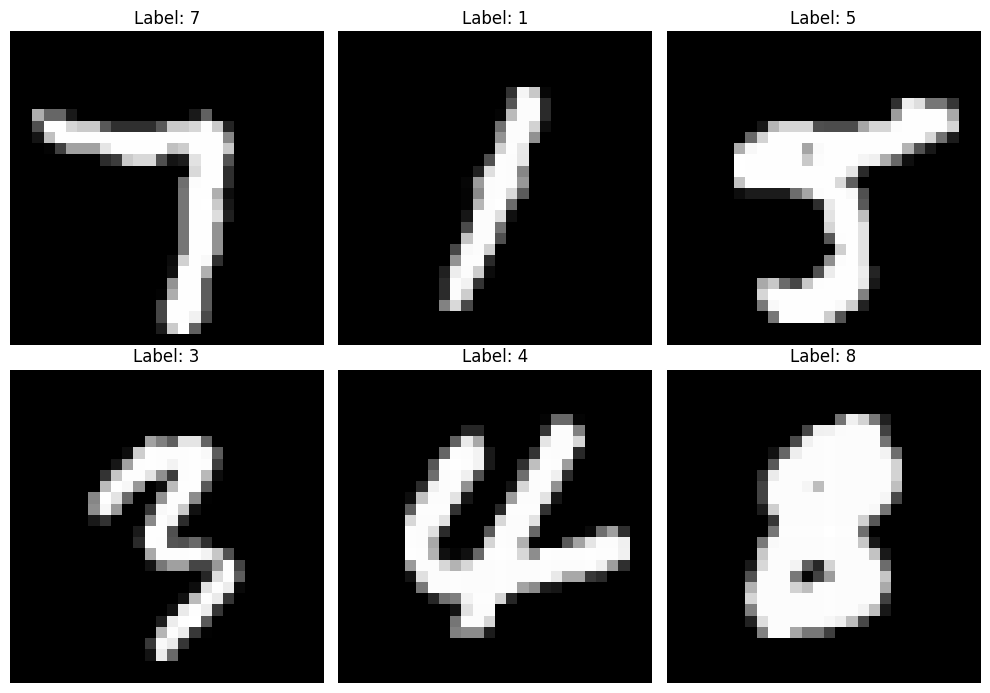

In [20]:
def plot_mnist_img(pixels, label, ax=None):
    pixels = pixels.numpy()
    pixels = pixels.reshape((28, 28))

    if ax is None:
        fig, ax = plt.subplots()
        show_plot = True
    else:
        show_plot = False

    ax.set_title(f"Label: {label}")
    ax.imshow(pixels, cmap="gray")
    ax.axis('off')  # Hide axes for cleaner look

    if show_plot:
        plt.show()

# Create a figure and a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for ax in axes:
    rand_item = random.choice(mnist_test_set)
    pixels_tensor, label = rand_item

    plot_mnist_img(pixels_tensor, label, ax=ax)

plt.tight_layout()
plt.show()

# Define the Encoder and Decoder Modules

We define our neural network by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward()` method.

The `forward()` method of the encoder expects as argument a tensor of dimensions *batch_dim* x 28 x 28, and infers the mean and log-variance of the latent space Gaussians. Conversely, the decoder takes a tensor of dimensions *batch_dim* x *latent_space_size* and reconstructs the original image.

In [21]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()

        # Setup three linear transformations
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

        # Setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # Define the forward computation on the image x
        # First shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)

        # Then compute the hidden units
        hidden = self.softplus(self.fc1(x))

        # Return a mean vector and a the log variance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_logvar = self.fc22(hidden)

        return z_loc, z_logvar

In [22]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()

        # Setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)

        # Setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # Define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))

        # Return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        loc_img = loc_img.view(-1, 28, 28)

        return loc_img

In [23]:
encoder = Encoder(z_dim=50, hidden_dim=100)
print(encoder)

decoder = Decoder(z_dim=50, hidden_dim=100)
print(decoder)

Encoder(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc21): Linear(in_features=100, out_features=50, bias=True)
  (fc22): Linear(in_features=100, out_features=50, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)
Decoder(
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (fc21): Linear(in_features=100, out_features=784, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (sigmoid): Sigmoid()
)


# The Variational Autoencoder in PyTorch

To allow the passage of the gradient, we use the reparameterization trick for the Gaussian distribution:
$$
    \mathbf{z} = \mathbf{\mu} + \mathbf{\sigma} \mathbf{\epsilon}
$$
where $\mathbf{\epsilon} \sim \mathcal{N}(0, 1)$

Our loss function is the ELBO:
$$
    \textrm{ELBO} = \mathbb{E}_{q_{\lambda} (\mathbf{z})} \left[ \log p_{\theta} (\mathbf{x}, \mathbf{z}) - \log q_{\lambda} (\mathbf{z}) \right]
$$

$$
    \textrm{ELBO} = \mathbb{E}_{q_{\lambda} (\mathbf{z})} \left[ \log p_{\theta}(\mathbf{x} \mid \mathbf{z}) \right] - D_{\text{KL}} \left[ q_{\lambda}(\mathbf{z} \mid \mathbf{x}) \mid \mid p_{\theta}(\mathbf{z}) \right]
$$

We've chosen as our variational family a mean-field Gaussian posterior for our latent space. We can thus derive and use the closed form ELBO for Gaussian latents (see [here](https://arxiv.org/pdf/1907.08956.pdf) for a full derivation):
$$
    \mathcal{L} = - \sum_{j=1}^J \frac{1}{2} \left[ 1 + \log \sigma_j^2 - \sigma_j^2 - \mu_j^2 \right] - \frac{1}{L} \sum_l \mathbb{E}_{z \sim q(z \mid x_l)} \left[ \log p (x_l \mid z_l) \right]
$$

In [24]:
class VAEPyTorch(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()

        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into GPU memory
            self.cuda()

        self.use_cuda = use_cuda
        self.z_dim = z_dim

    def forward(self, input_data: torch.Tensor):
        mu, logvar = self.encoder(input_data)
        latent_sample = self.reparameterize(mu, logvar)
        reconstructed_inputs = self.decoder(latent_sample)

        return input_data, reconstructed_inputs, mu, logvar

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return mu + std * eps


    def loss_function(
        self, input_data, reconstructions, mu, logvar, beta
    ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons_loss = torch_functional.mse_loss(reconstructions, input_data)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

        loss = recons_loss + beta * kld_loss

        return {"total_loss": loss, "reconstruction_loss": recons_loss.detach(), "KLD": -kld_loss.detach()}

Now that we have our data and our model we can proceed with training.


Inside the training loop, optimization happens in three steps:
 - Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 - Backpropagate the prediction loss with a call to `loss.backward()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 - Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

In [25]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.001

In [26]:
vae_pytorch = VAEPyTorch(z_dim=50, hidden_dim=100, use_cuda=USE_CUDA)
optimizer = torch.optim.Adam(vae_pytorch.parameters(), lr=LEARNING_RATE)

In [27]:
for epoch_num in range(NUM_EPOCHS):
    for batch_num, (pixels, _) in enumerate(mnist_train_loader):
        if USE_CUDA:
            pixels = pixels.to("cuda")
            # labels = labels.to("cuda")

        # Do NOT use directly forward()!
        input_data, reconstructed_inputs, mu, logvar = vae_pytorch(pixels)
        losses = vae_pytorch.loss_function(
            pixels.squeeze(), reconstructed_inputs, mu, logvar, 0.001
        )
        loss = losses["total_loss"]

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_num % 400 == 0:
            print(f"epoch_num: {epoch_num + 1}; batch_num: {batch_num}; loss: {loss.item():>7f}")

epoch_num: 1; batch_num: 0; loss: 0.254559
epoch_num: 1; batch_num: 400; loss: 0.061475
epoch_num: 1; batch_num: 800; loss: 0.051233
epoch_num: 2; batch_num: 0; loss: 0.048064
epoch_num: 2; batch_num: 400; loss: 0.048623
epoch_num: 2; batch_num: 800; loss: 0.044071
epoch_num: 3; batch_num: 0; loss: 0.044753
epoch_num: 3; batch_num: 400; loss: 0.040002
epoch_num: 3; batch_num: 800; loss: 0.040051
epoch_num: 4; batch_num: 0; loss: 0.044244
epoch_num: 4; batch_num: 400; loss: 0.040881
epoch_num: 4; batch_num: 800; loss: 0.039218
epoch_num: 5; batch_num: 0; loss: 0.040724
epoch_num: 5; batch_num: 400; loss: 0.041050
epoch_num: 5; batch_num: 800; loss: 0.035521


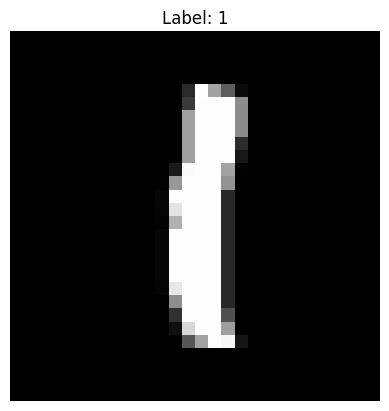

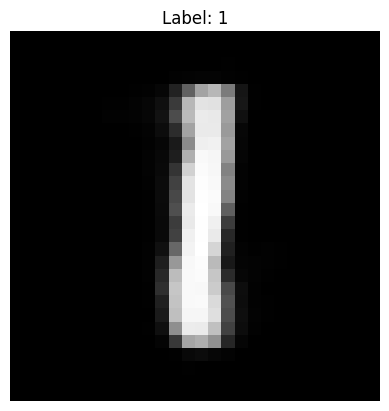

In [28]:
# Pick a random item from the test set
rand_item = random.choice(mnist_test_set)
pixels_tensor, label = rand_item

# Run it through the model to get the reconstruction
if USE_CUDA:
    _, reconstructed_inputs, _, _ = vae_pytorch(pixels_tensor.cuda())
    reconstructed_pixels = reconstructed_inputs.detach().cpu()
else:
    _, reconstructed_inputs, _, _ = vae_pytorch(pixels_tensor)
    reconstructed_pixels = reconstructed_inputs.detach()

# Plot the original and reconstructed image
plot_mnist_img(pixels_tensor, label)
plot_mnist_img(reconstructed_pixels, label)

# The Variational Autoencoder in Pyro

Probabilistic models in Pyro are specified as Python functions `model(*args, **kwargs)` that generate observed data from latent variables using special primitive functions whose behavior can be changed by Pyro’s internals depending on the high-level computation being performed.

Specifically, the different mathematical pieces of `model()` are encoded via the mapping:
 + latent random variables - `pyro.sample`
 + observed random variables - `pyro.sample` with the `obs` keyword argument
 + learnable parameters - `pyro.param`
 + plates - `pyro.plate` context managers

The basic idea behind VI is that we introduce a parameterized distribution $q_{\phi}(\mathbf{z})$ called the variational distribution that will serve as an approximation to the posterior. We can think of $\phi$ as parameterizing a space or family of probability distributions. Our goal will be to find the (not necessarily unique) probability distribution in that space that is the best possible approximation to the posterior distribution.

Just like the model, the guide is encoded as a stochastic function `guide()` that contains `pyro.sample` and `pyro.param` statements, but can't contain observed data. Pyro furthermore enforces that `model()` and `guide()` have the same call signature, i.e. both callables should take the same arguments.

What happens under the hood is Black Box Variational Inference that, unlike before, doesn't require us to perform any significant model-specific analysis.
Instead, stochastic optimization of the variational objective is performed, where the noisy gradient of the ELBO objective is computed from Monte Carlo samples from the variational distribution.

The algorithm used is briefly described below, but refer to [the paper](http://proceedings.mlr.press/v33/ranganath14.pdf) for additional details:

**Inputs:** data $x$, joint distribution $p$, mean field variational family $q$.
1. **Initialize:** $\lambda$ randomly, $t = 1$.
2. **repeat**
   - **Draw $S$ samples from $q$:**

     $
     \text{for } s = 1 \text{ to } S \text{ do} \\
     $

     $
     \quad z^{(s)} \sim q(\cdot | \lambda) \\
     $

     $
     \text{end for}
     $
   - **Set $\epsilon_t$ to the $t$-th value of a Robbins-Monro sequence**
   - **Update $\lambda$:**
     $$
     \lambda = \lambda + \epsilon_t \frac{1}{S} \sum_{s=1}^S \nabla_\lambda \log q(z^{(s)} | \lambda)
     \left( \log p(x, z^{(s)}) - \log q(z^{(s)} | \lambda) \right)
     $$
   - **Increment $t$:**
     $$
     t = t + 1
     $$
3. **until** change in $\lambda$ is less than $0.01$.

In [29]:
class VAEPyro(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()

        # Create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()

        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # Define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)

        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))

            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode the latent code z
            loc_img = self.decoder(z).view(-1, 784)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)

        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, logvar = self.encoder(x)
            z_scale = torch.exp(logvar)

            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, logvar = self.encoder(x)
        z_scale = torch.exp(logvar)

        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()

        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [30]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train

    return total_epoch_loss_train

In [31]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set

    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)

    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test

    return total_epoch_loss_test

In [32]:
pyro.distributions.enable_validation(False)

In [33]:
train_loader, test_loader = mnist_train_loader, mnist_test_loader

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAEPyro(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch + 1, total_epoch_loss_train))

[epoch 001]  average training loss: 160.4150
[epoch 002]  average training loss: 125.5594
[epoch 003]  average training loss: 116.1663
[epoch 004]  average training loss: 112.4026
[epoch 005]  average training loss: 110.2676


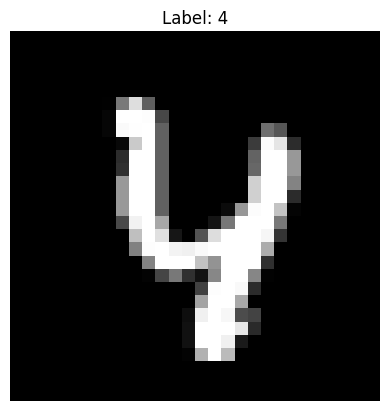

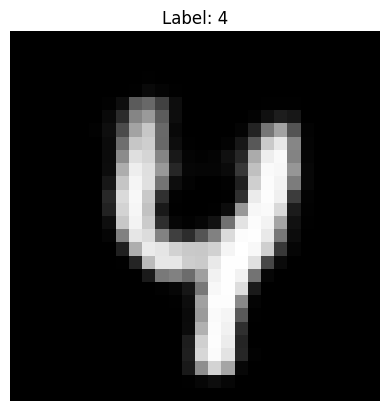

In [34]:
rand_item = random.choice(mnist_test_set)
pixels_tensor, label = rand_item

if USE_CUDA:
    reconstructed_inputs = vae.reconstruct_img(pixels_tensor.cuda())
    reconstructed_pixels = reconstructed_inputs.detach().cpu()
else:
    reconstructed_inputs = vae.reconstruct_img(pixels_tensor)
    reconstructed_pixels = reconstructed_inputs.detach()

plot_mnist_img(pixels_tensor, label)
plot_mnist_img(reconstructed_pixels, label)

# References
[1] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.

[2] Blei, D. M., Kucukelbir, A., & McAuliffe, J. D. (2017). Variational inference: A review for statisticians. Journal of the American statistical Association, 112(518), 859-877.

[3] Ranganath, R., Gerrish, S., & Blei, D. (2014, April). Black box variational inference. In Artificial intelligence and statistics (pp. 814-822). PMLR.

[4] Nunn, N., & Puga, D. (2012). Ruggedness: The blessing of bad geography in Africa. Review of Economics and Statistics, 94(1), 20-36.

[5] Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.


***Code and examples adapted from:***

https://pyro.ai/examples/intro_long.html

https://pyro.ai/examples/svi_part_i.html

https://pyro.ai/examples/svi_part_iii.html

https://pyro.ai/examples/vae.html

https://pytorch.org/tutorials/beginner/basics/intro.html
